In [35]:
import scanpy as sc
import anndata
#import pl
#import tl
import numpy as np
import time as time

# Load Dataset
filelocation = r"datasets/VBh_converted.h5ad"
adata = anndata.read_h5ad(filelocation)

# subsampling
sc.pp.subsample(adata, 0.4)

# normalizing
adata.X = np.arcsinh(adata.X / 10)

# calc knn
sc.pp.neighbors(adata, n_neighbors=20)

Trying to set attribute `.uns` of view, copying.


With calculated landmarks
1.0


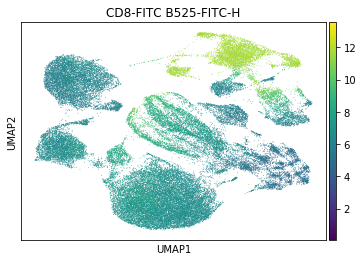

Trying to set attribute `.uns` of view, copying.


0.8875


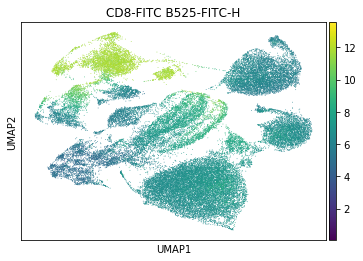

Trying to set attribute `.uns` of view, copying.


0.775


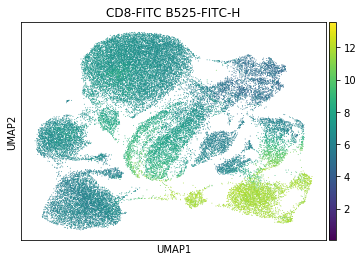

Trying to set attribute `.uns` of view, copying.


0.6625


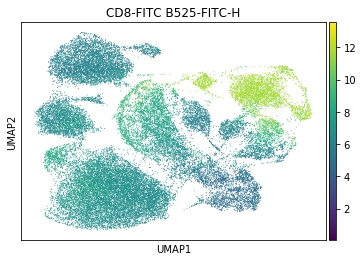

Trying to set attribute `.uns` of view, copying.


0.55


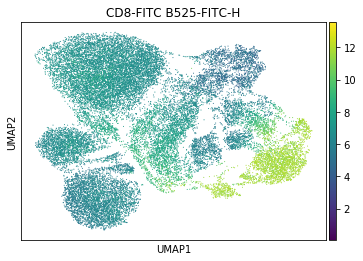

Trying to set attribute `.uns` of view, copying.


0.4375


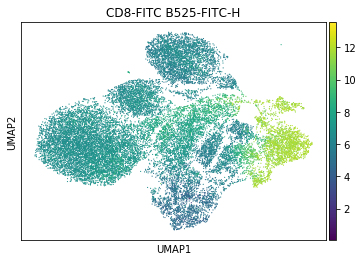

Trying to set attribute `.uns` of view, copying.


0.32499999999999996


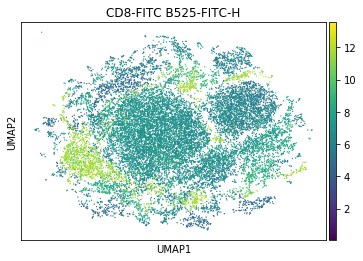

Trying to set attribute `.uns` of view, copying.


0.21250000000000002


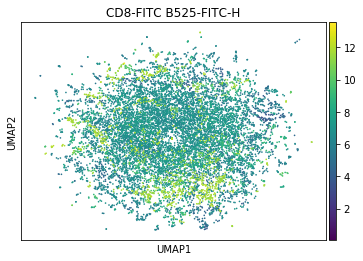

Trying to set attribute `.uns` of view, copying.


0.1


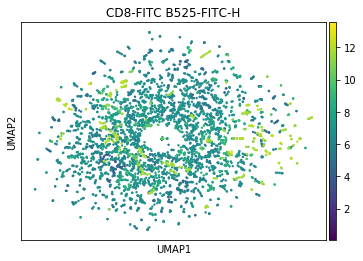

In [36]:
# concentrated

c = adata.obsp['connectivities']

T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

D, V = eigs(T.T, which='LM')

pi = V[:, 0]

pi = pi.real

pi /= pi.sum()

Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])


###########

for part in np.linspace(1,0.1,9):
    print(part)
    speichi = adata.copy()
    speichi = speichi[pi.argsort()[:int(len(adata)*part)]]
    sc.tl.umap(speichi)
    sc.pl.umap(speichi, color=adata.var_names.values[4])

In [26]:
print(np.linspace(1,0,10))

[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ]


In [2]:
def _calc_P(T):
    return (T + T.transpose()) / (2 * T.shape[0])

In [3]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs

def fresh_calc_T(c): # param c: adata.obsp['connectivities']
    # get connectivities from adata
    # --> done via parameter

    # make sure connectivities are symmetric
    assert(len((c - c.T).data) == 0), "connectivities are not symmetric"

    # row-normalise c to give a transition matrix
    T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

    # make sure it's correctly row-normalised
    assert(np.allclose(T.sum(1), 1)), "T is not row-normalised"

    # compute the stationary distribution
    #from scipy.sparse.linalg import eigs
    D, V = eigs(T.T, which='LM')
    pi = V[:, 0]

    # make sure pi is entirely real
    assert((pi.imag == 0).all()), "This is not the stationary vector, found imaginary entries"
    pi = pi.real

    # make sure all entries have the same sign
    assert((pi > 0).all() or (pi < 0).all()), "This is not the stationary vector, found positive and negative entries"
    pi /= pi.sum()

    # check pi is normalised correctly
    assert(np.allclose(pi.sum(), 1)), "Pi is not normalized correctly"

    # put the stationary dist into a diag matrix
    Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

    # finally, check for reversibility of T
    assert(np.allclose((Pi @ T - T.T @ Pi).data, 0))
    
    # list of landmarks
    
    
    return T
    
t0_new = time.time()
T_new = fresh_calc_T(adata.obsp['connectivities'])
t1_new = time.time()

In [4]:
# compared to old method for calculating T
import multiprocessing as mp
from scipy.special import softmax
from scipy.stats import entropy

def _calc_first_T(distances_nn, dim):
    p = mp.Pool(mp.cpu_count())
    probs = p.map(_helper_method_calc_T, [dist.data for dist in distances_nn])
    p.terminate()
    p.join()
    data = []
    for pr in probs:
        data.extend(pr)
    T = csr_matrix((data, distances_nn.indices, distances_nn.indptr), shape=(dim,dim))
    return T

def _helper_method_calc_T(dist):
    d = dist / np.max(dist)
    return softmax((-d ** 2) / _binary_search_sigma(d, len(d)))

def _binary_search_sigma(d, n_neigh):
    # binary search
    sigma = 10  # Start Sigma
    goal = np.log(n_neigh)  # log(k) with k being n_neighbors
    # Do binary search until entropy ~== log(k)
    while True:
        ent = entropy(softmax((-d ** 2) / sigma))
        # check sigma
        if np.isclose(ent, goal):
            return sigma
        if ent > goal:
            sigma *= 0.5
        else:
            sigma /= 0.5


t0_old = time.time()
T_old = _calc_first_T(adata.obsp['distances'], len(adata.X))

t1_old = time.time()



In [5]:
print("--NEW--")
print(f"shape: {np.shape(T_new)}")
print(f"T num entrys: {len(T_new.data)}")
print(f"sum of data: {sum(T_new.data)}")
P_new = _calc_P(T_new)
print(f"sum first row P {sum(sum((P_new.getrow(0)).toarray()))}")
print(f"length first row P {P_new[0].getnnz()}")
print(f"P max {max(P_new.data)}")
print(f"P min {min(P_new.data)}")
print(f"sum first row T {sum(sum((T_new.getrow(0)).toarray()))}")
print(f"T max {max(T_new.data)}")
print(f"T min {min(T_new.data)}")
print(f"time: {t1_new-t0_new}\n")

print("--OLD--")
print(f"shape: {np.shape(T_old)}")
print(f"T num entrys: {len(T_old.data)}")
print(f"sum of data: {sum(T_old.data)}")
P_old = _calc_P(T_old)
print(f"sum first row P {sum(sum((P_old.getrow(0)).toarray()))}")
print(f"length first row P {P_old[0].getnnz()}")
print(f"P max {max(P_old.data)}")
print(f"P min {min(P_old.data)}")
print(f"sum first row T {sum(sum((T_old.getrow(0)).toarray()))}")
print(f"T max {max(T_old.data)}")
print(f"T min {min(T_old.data)}")
print(f"time: {t1_old-t0_old}\n")


--NEW--
shape: (6473, 6473)
T num entrys: 173636
sum of data: 6472.99999501581
sum first row P 0.00015586926104728505
length first row P 27
P max 3.574517158863074e-05
P min 7.363638917086929e-10
sum first row T 0.9999999972060323
T max 0.23137864470481873
T min 4.644946784537751e-06
time: 0.07952308654785156

--OLD--
shape: (6473, 6473)
T num entrys: 122987
sum of data: 6472.999999999982
sum first row P 0.0001504339110220553
length first row P 27
P max 8.338319907786854e-06
P min 4.001168756584085e-06
sum first row T 0.9999999999999993
T max 0.054054882620180454
T min 0.05179913072273756
time: 0.672086238861084



In [6]:
# OLD LANDMARKS
def _get_landmarks(T, settings):

    n_events = T.shape[0]
    proposals = np.zeros(n_events)  # counts how many times point has been reached
    landmarks = list()  # list of landmarks
    global HELPER_VAR
    HELPER_VAR = {'T': T,
                  'teta': settings['teta'],
                  'beta': settings['beta'],
                  'beta_thresh': settings['beta_thresh'],
                  'n_events': n_events}
    init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
    p = mp.Pool(mp.cpu_count())
    hit_list = p.map(_helper_method_get_landmarks, [state for state in init_states])
    p.terminate()
    p.join()
    # evaluate results
    for state_hits in hit_list:  # for every states hit_list
        for h in state_hits:  # for every hit in some states hit_list
            proposals[h[0]] += h[1]

    # collect landmarks
    min_beta = settings['beta'] * settings['beta_thresh']
    for prop in enumerate(proposals):
        # if event has been hit min_beta times, it counts as landmark
        if prop[1] > min_beta:
            landmarks.append(prop[0])
    return landmarks

def _helper_method_get_landmarks(state):
    for i in range(HELPER_VAR['teta']):
        state *= HELPER_VAR['T']
    destinations = np.random.choice(range(HELPER_VAR['n_events']), HELPER_VAR['beta'], p=state.toarray()[0])
    hits = np.zeros((HELPER_VAR['n_events']))
    for d in destinations:
        hits[d] += 1
    return [(h[0], h[1]) for h in enumerate(hits) if h[1] > 0]

##################


# NEW LANDMARKS
def fresh_calc_lm(T):

    # make sure it's correctly row-normalised
    assert(np.allclose(T.sum(1), 1)), "T is not row-normalised"

    # compute the stationary distribution
    #from scipy.sparse.linalg import eigs
    D, V = eigs(T.T, which='LM')
    pi = V[:, 0]

    # make sure pi is entirely real
    #assert((pi.imag == 0).all()), "This is not the stationary vector, found imaginary entries"
    pi = pi.real

    # make sure all entries have the same sign
    #assert((pi > 0).all() or (pi < 0).all()), "This is not the stationary vector, found positive and negative entries"
    pi /= pi.sum()

    # check pi is normalised correctly
    assert(np.allclose(pi.sum(), 1)), "Pi is not normalized correctly"

    # put the stationary dist into a diag matrix
    Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

    # finally, check for reversibility of T
    #assert(np.allclose((Pi @ T - T.T @ Pi).data, 0))
    
    # new: get rid of negative stuff
    pi += abs(min(pi))
    pi /= sum(pi)
    
    # list of landmarks
    return pi, pi.argsort()

##################

settings = {'T': T_old,
              'teta': 50,
              'beta': 100,
              'beta_thresh': 1.5,
              'n_events': T_old.shape[0]}
print(f"n_events: {settings['n_events']}")

#lm_old = _get_landmarks(T_old, settings)
#print('lm_old')
#print(lm_old[:10])
#print(len(lm_old))

pi, lm_new = fresh_calc_lm(T_old)
print('lm_new')
print(lm_new.sort())
print("pi:")
print(pi[:10])
print(len(pi))
print("lm_new:")
print(lm_new[:10])
print(len(lm_new))


n_events: 6473
lm_new
None
pi:
[0.00015447 0.00015449 0.00015449 0.00015444 0.00015483 0.0001545
 0.00015449 0.0001545  0.00016443 0.00015557]
6473
lm_new:
[0 1 2 3 4 5 6 7 8 9]
6473


In [7]:
def calc_lm(adata):
    # get connectivities from adata
    c = adata.obsp['connectivities']

    # make sure connectivities are symmetric
    assert(len((c - c.T).data) == 0), "connectivities are not symmetric"

    # row-normalise c to give a transition matrix
    T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

    # make sure it's correctly row-normalised
    assert(np.allclose(T.sum(1), 1)), "T is not row-normalised"

    # compute the stationary distribution
    #from scipy.sparse.linalg import eigs
    D, V = eigs(T.T, which='LM')
    pi = V[:, 0]

    # make sure pi is entirely real
    assert((pi.imag == 0).all()), "This is not the stationary vector, found imaginary entries"
    pi = pi.real

    # make sure all entries have the same sign
    assert((pi > 0).all() or (pi < 0).all()), "This is not the stationary vector, found positive and negative entries"
    pi /= pi.sum()

    # check pi is normalised correctly
    assert(np.allclose(pi.sum(), 1)), "Pi is not normalized correctly"

    # put the stationary dist into a diag matrix
    Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

    # finally, check for reversibility of T
    assert(np.allclose((Pi @ T - T.T @ Pi).data, 0))
    
    # new: get rid of negative stuff
    pi += abs(min(pi))
    pi /= sum(pi)
    
    # list of landmarks
    return pi, pi.argsort()

pi, lm = calc_lm(adata)




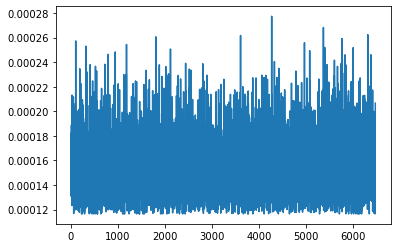

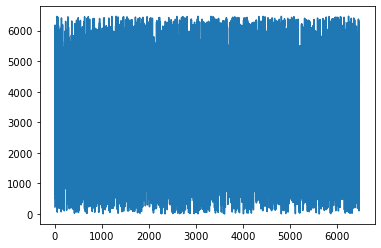

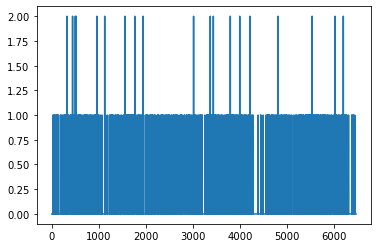

Sorted:


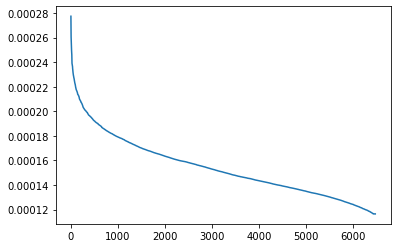

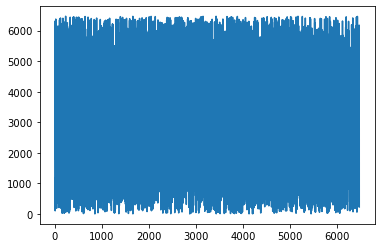

[0.00027741998, 0.00026827265, 0.0002624474, 0.00026173066, 0.000260656, 0.0002592137, 0.0002573132, 0.0002559036, 0.0002544647, 0.0002530895]
[4269, 5369, 6313, 3607, 1805, 5764, 102, 4966, 1182, 318]


In [8]:
import matplotlib.pyplot as plt


plt.plot(pi)
plt.show()
plt.plot(lm)
plt.show()

ch = np.random.choice(len(pi), size=500, p=pi)
x = np.zeros(len(lm))
for i in ch:
    x[i] = x[i] + 1
    
plt.plot(x)
plt.show()



print('Sorted:')

lm2 = range(len(pi))
pi2, lm2 = (list(t) for t in zip(*sorted(zip(pi, lm2), reverse=True)))
plt.plot(pi2)
plt.show()
plt.plot(lm2)
plt.show()
print(pi2[:10])
print(lm2[:10])
